# NGC UHS4 FOU GWAS
__Author:__ Jesse Marks

This document logs the steps taken to perform a GWAS on the UHS4 data using the frequency of opioid use (FOU) phenotype. 

## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* GNU bash version 4.1.2
* [PLINK v1.9 beta 3.45](https://www.cog-genomics.org/plink/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* R packages: MASS, moments
* [RVtests](https://render.githubusercontent.com/view/ipynb?commit=3bb8e661ad8b75af027ed2748133452ec251aaed&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f525449496e7465726e6174696f6e616c2f6271756163685f6e6f7465626f6f6b732f336262386536363161643862373561663032376564323734383133333435326563323531616165642f6865726f696e5f70726f6a6563742f646576656c6f702f32303138303131305f756873325f756873335f666f755f677761732e6970796e623f746f6b656e3d41664d79344e373237626e764465456f46535a697770346b48776246577964706b7335617570495a7741253344253344&nwo=RTIInternational%2Fbquach_notebooks&path=heroin_project%2Fdevelop%2F20180110_uhs2_uhs3_fou_gwas.ipynb&repository_id=105297875&repository_type=Repository)

## Data description
### genotype data
Downloaded from s3://rti-midas-data/studies/uhs4/observed/genotypes/final .
```
wc -l uhs4.merged2.ea.fam
    989 uhs4.merged2.ea.fam
wc -l uhs4.merged2.aa.fam
    1072 uhs4.merged2.aa.fam
```

### phenotype data
These data were processed by Jesse Marks. The data and more details are located in [GitHub Issue 117](https://github.com/RTIInternational/bioinformatics/issues/117#issuecomment-488342692).


### Variable information
__FOU Variables__:
* age
* sex_selfreport
    * 1=Male and 2=Female, according to [Bryan Quach's notebook](https://github.com/RTIInternational/bquach_notebooks/blob/master/heroin_project/develop/20180110_uhs2_uhs3_fou_gwas.ipynb). For the NGC protocol, these need to be reversed.
* totopioid_tot_30d

The FOU phenotype will be defined as:

$$zscore(boxcox(\text{totopioid_tot_30d}+1))$$

__Note__: remove any individual with any of these data missing.

# Download Data and Create Directory Structure

In [152]:
## create directory structure ##
genD=/shared/jmarks/heroin/uhs4/genotype/observed/final/v1 # location of QC'ed genotype data
gwasD=/shared/jmarks/heroin/uhs4/gwas/fou # base processing dir
phenD=/shared/jmarks/heroin/uhs4/phenotype # base phenotype dir
eig=$phenD/processing/eig # location of PCA processing dir
ancestry="ea"
study=uhs4
mkdir -p $genD $gwasD $phenD/{final,processing,unprocessed} $eig/results 


## Dowload imputed genotype data ##
cd /shared/jmarks/heroin/uhs4/genotype/imputed/v1
for ancestry in ea aa;do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name download_${ancestry} \
        --script_prefix $ancestry/s3.download \
        --mem 3.5 \
        --nslots 1 \
        --priority 0 \
        --program aws s3 sync s3://rti-midas-data/studies/uhs4/imputed/v1/imputations/$ancestry/output_files/ $ancestry/
done


## Dowload observed genotype data ##
cd /shared/jmarks/heroin/uhs4/genotype/observed/final/v1
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name download_uhs4 \
        --script_prefix s3.download \
        --mem 3.5 \
        --nslots 1 \
        --priority 0 \
        --program aws s3 sync s3://rti-midas-data/studies/uhs4/observed/genotypes/final/ .
done

## Download semi-processed phenotype data ##
cd /shared/jmarks/heroin/uhs4/phenotype/processing
aws s3 sync s3://rti-heroin/uhs4/data/phenotype/ .

ERROR: Error in parse(text = x, srcfile = src): <text>:2:6: unexpected '/'
1: ## create directory structure ##
2: genD=/
        ^


# Prepare Files for Analysis
We follow the process outlined in the NGC protocol for preperations of the phenotype file, even if we don't ultimately use RVTESTS for the analysis. This is so that the phenotype processing steps are consistent.

## Phenotype processing
Create phenotype files for the GWAS. We follow the instructions of the NGC protocol distributed by Eric Johnson. This protocol mandates that we create a phenotype file and a covariate file in PED format. See the NGC protocol for more information on this format. There are several initial filters and processing steps to be applied to the subject data.

* extract ids of subjects passing genotype QC
* Map sex coding per the NGC protocol, to 1=female & 2=male. 

### Data Wrangling

In [ ]:
## map sex code ##
# AA
for an in aa ea; do
    awk 'NR>1{if ( $3==1) { $3=2} else { $3=1 }} {print $0} ' \
        $phenD/processing/20190509-uhs4-$an-fou-phenotype-file.txt >\
        $phenD/processing/$study.$an.phenotype_table.sex_mapped
done

## filter phenotype data to subjects that passed genotype QC ##
for an in ea aa; do
    cut -d ' ' -f2 $genD/$study.merged2.$an.fam > $phenD/processing/$study.$an.genotype.IDs
done
for an in ea aa; do
    awk 'NR==1{print $0}; FNR==NR{ map[$1]=$0; next} {print map[$1]} ' \
        $phenD/processing/uhs4.$an.phenotype_table.sex_mapped $study.$an.genotype.IDs\
        > $phenD/processing/$study.$an.phenotype_table.sex_mapped.passed_qc
done

### Phenotype visualization
#### Box-Cox Transformation
Remove individuals with a 0 for FOU and then shift the Box-Cox transformation to a left-anchored distribution at 1.0 (i.e. 1.0 being the lowest value: e.g., once per day or one day per month). Also, add constant 1 to all responses to deal with the fractional responses that are less than 1? 

| Ancestry | Samples Removed (FOU==0) | Total Samples |
|----------|--------------------------|---------------|
| EA       | 128                      | 861           |
| AA       | 152                      | 920           |

In [ ]:
### R console ###
library(MASS)
options(repr.plot.width=10, repr.plot.height=17)
# note that I copied over the phenotype data to my local machine to produce the plots
setwd('C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/gwas/fou')

ea.fou.data <- read.table("uhs4.ea.phenotype_table.sex_mapped.passed_qc", header = T)
aa.fou.data <- read.table("uhs4.aa.phenotype_table.sex_mapped.passed_qc", header = T)

cat("EA count: ", length(ea.fou.data$totopioid_tot_30d), "\n\n")
cat("AA count: ", length(aa.fou.data$totopioid_tot_30d), "\n\n\n\n")


## Remove individuals with 0 for FOU
ea.fou.data <- ea.fou.data[which(ea.fou.data$totopioid_tot_30d!=0),]
aa.fou.data <- aa.fou.data[which(aa.fou.data$totopioid_tot_30d!=0),]
cat("EA count after removing samples with FOU==0: ", length(ea.fou.data$totopioid_tot_30d), "\n\n")
cat("AA count after removing samples with FOU==0: ", length(aa.fou.data$totopioid_tot_30d), "\n\n")

par(mfrow=c(4,2))
## Perform boxcox transform ##
ea.boxcox <- boxcox(totopioid_tot_30d+1 ~ age + sex_selfreport, data=ea.fou.data)
aa.boxcox <- boxcox(totopioid_tot_30d+1 ~ age + sex_selfreport, data=aa.fou.data)
ea.lambda <- ea.boxcox$x[which(ea.boxcox$y==max(ea.boxcox$y))]
aa.lambda <- aa.boxcox$x[which(aa.boxcox$y==max(aa.boxcox$y))]

### Convert to Z-scores ##
ea.zscore <- scale((ea.fou.data$totopioid_tot_30d+1)^ea.lambda, center=T, scale=T)
aa.zscore <- scale((aa.fou.data$totopioid_tot_30d+1)^aa.lambda, center=T, scale=T)

hist(ea.fou.data$totopioid_tot_30d+1, breaks=30, col="red3", 
     border="white", main="EA FOU (totopioid_tot_30d)", xlab="FOU")
hist(aa.fou.data$totopioid_tot_30d+1, breaks=30, col="red3", 
     border="white", main="AA FOU (totopioid_tot_30d)", xlab="FOU")
hist((ea.fou.data$totopioid_tot_30d+1)^ea.lambda, breaks=30, col="red3",
     border="white", main="EA FOU Box-Cox", xlab="Transformed FOU")
hist((aa.fou.data$totopioid_tot_30d+1)^aa.lambda, breaks=30, col="red3",
     border="white", main="AA FOU Box-Cox", xlab="Transformed FOU")
hist(ea.zscore, breaks=30, col="red3", border="white", main="EA FOU Z-scores", xlab="Z-score", xlim=c(-2,3))
hist(aa.zscore, breaks=30, col="red3", border="white", main="AA FOU Z-scores", xlab="Z-score", xlim=c(-2,3))

aa.fou.data$totopioid_tot_30d <- aa.zscore
ea.fou.data$totopioid_tot_30d <- ea.zscore

write.table(ea.fou.data,"uhs4.ea.phenotype_table.sex_mapped.passed_qc.box_cox" , sep = "\t", row.names = F, quote=F)
write.table(aa.fou.data,"uhs4.aa.phenotype_table.sex_mapped.passed_qc.box_cox" , sep = "\t", row.names = F, quote=F)

#### Age + Sex 

In [ ]:
options(repr.plot.width=10, repr.plot.height=5)

#cat("========EA Age Table========")
#table(ea.fou.data$age)
#cat("\n\n========AA Age Table========")
#table(aa.fou.data$age)

cat("========EA Sex Table========")
table(ea.fou.data$sex)
cat("\n\n========AA Sex Table========")
table(aa.fou.data$sex)

par(mfrow=c(1,2))

# Plot age
hist(ea.fou.data$age, breaks=30, col="red3", border="white",
     main="EA Age Distribution", xlab="Age in Years")
hist(aa.fou.data$age, breaks=30, col="red3", border="white",
     main="AA Age Distribution", xlab="Age in Years")

par(mfrow=c(1,2))
# Plot sex
hist(ea.fou.data$sex, breaks=2, col="blue3", border="white", 
     main="EA Sex Distribution", xlab="1=Female, 2=Male", labels=T, ylim= c(0,700))
hist(aa.fou.data$sex, breaks=2, col="blue3", border="white", 
     main="AA Sex Distribution", xlab="1=Female, 2=Male", labels=T, ylim= c(0,700))


In [ ]:
## upload to EC2
cd /shared/jmarks/heroin/uhs4/phenotype/processing
scp -i ~/.ssh/gwas_rsa *box_cox ec2-user@34.206.166.72:/shared/jmarks/heroin/uhs4/phenotype/processing/

## Control for Population Stratification (EIGENSTRAT)
In a GWAS model, one should control for population stratification (or ancestry structure). Population stratification in GWA studies can lead to spurious correlations or reduced power. One can control for stratification by including in the GWAS statisical model the top genotype principal components (PCs) as covariates. These genotype PCs capture the phenotypic variance explained by population stratification.

Here we use the software tool EIGENSTRAT that performs a PCA on the genotype data. EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group.

### Construct subject-filtered PLINK file sets
Generate a new set of genotype data filtered by the phenotype information. Perform LD-pruning on these observed genotype data for the PCA. 

In [ ]:
## generate new set of genotype data ##
for an in aa ea; do
    awk 'NR>=2{print $1,$1}' $phenD/processing/$study.$an.phenotype_table.sex_mapped.passed_qc.box_cox > \
        $phenD/processing/$study.$an.final_ids

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genD/uhs4.merged2.$an \
        --keep $phenD/processing/$study.$an.final_ids \
        --make-bed \
        --out $eig/$study.$an.genotypes
done

### Remove high-LD region variants

In [ ]:
# Remove high-LD region variants
for an in aa ea; do
    # Generate list of variants in known high-LD regions
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/$study.$an.genotypes.bim  > $eig/$study.$an.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes \
        --exclude $eig/$study.$an.high_ld_regions.remove \
        --make-bed \
        --out $eig/${an}_high_ld_regions_removed
done &

### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using PLINK `--indep-pairwise.`

In [ ]:
# Remove high-LD region variants
for an in aa ea; do
    # Run per chromosome LD pruning for each chr
    for chr in {1..23}; do
         /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${an}_${chr}_ld_prune \
            --script_prefix $eig/${an}_${chr}_ld_prune \
            --mem 3.5 \
            --nslots 1 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 3500 \
                --bfile $eig/${an}_high_ld_regions_removed \
                --indep-pairwise 1500 150 0.2 \
                --chr ${chr} \
                --out $eig/${an}_chr${chr}_ld_pruned
    done
done

#Create LD pruned PLINK file sets
for ancestry in aa ea; do
    # Merge *prune.in files
    cat $eig/${ancestry}_chr*_ld_pruned.prune.in > $eig/${ancestry}_chr_all_ld_pruned.prune.in
    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $eig/${ancestry}_high_ld_regions_removed \
        --extract $eig/${ancestry}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/${ancestry}_ld_pruned
done


# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*qsub*
rm $eig/*nosex

wc -l $eig/*bim
wc -l $eig/*fam

### Rename BIM/FAM file IDs
Variant IDs in the PLINK bim file have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. The family IDs in the PLINK fam files similarly throw an error in smartpca should the number of characters in the IDs be more than 39. For this reason, we will apply an analogous renaming convention.

In [ ]:
# Count ID lengths greater than 39 characters
for ancestry in aa ea; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    awk '{ if(length($1)+length($2)>39){print $2} }' $eig/${ancestry}_ld_pruned.fam | wc -l
    awk '{ if(length($2)>39){print $2} }' $eig/${ancestry}_ld_pruned.bim | wc -l
done

for ancestry in aa ea; do
    # Rename FAM file IDs
    # Make new FAM
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/${ancestry}_ld_pruned.fam \
        > $eig/${ancestry}_ld_pruned_id_renamed.fam
    awk '{ if(length($1)+length($2)>39){print $2} }' $eig/${ancestry}_ld_pruned_id_renamed.fam | wc -l

#    # Rename BIM file IDs
#    # Make new BIM
#    awk '{$2="ID_"NR; print $0}' $eig/${ancestry}_ld_pruned.bim \
#        > $eig/${ancestry}_ld_pruned_id_renamed.bim
done

### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT bin directory should be in ~/.bashrc as an addition to the PATH variable. If it is not, it can be added as following

`export PATH=$PATH:/shared/bioinformatics/software/third_party/EIG-6.1.4/bin/` # Add EIGENSOFT bin to path

The `smartpca.pl` program documentation is shown below:


DOCUMENTATION of `smartpca.pl` program:

This program calls the `smartpca` program (see ../POPGEN/README). 
For this to work, the bin directory containing `smartpca` MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
# Run smartpca
for ancestry in aa ea; do
    famfile="$eig/${ancestry}_ld_pruned_id_renamed.fam"
    bimfile="$eig/${ancestry}_ld_pruned.bim"
    bedfile="$eig/${ancestry}_ld_pruned.bed"

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.smartpca.$ancestry \
        --script_prefix $eig/results/smartpca.$study.${ancestry} \
        --mem 7.5 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
            -i $bedfile \
            -a $bimfile \
            -b $famfile \
            -o $eig/results/${ancestry}_ld_pruned.pca \
            -p $eig/results/${ancestry}_ld_pruned.plot \
            -e $eig/results/${ancestry}_ld_pruned.eval \
            -l $eig/results/${ancestry}_ld_pruned.pca.log \
            -m 0
done

#### Extract Eigenvectors

In [ ]:
# Grab top 10 eigenvectors from PCA 
for ancestry in aa ea; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${ancestry}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
done

#### View PCs from EIGENSTRAT
Copy results over to local machine.

In [ ]:
## local machine ##
cd ~/Desktop/Projects/heroin/ngc/uhs4/phenotype/processing/eig
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/heroin/uhs4/phenotype/processing/eig/results/* .

In [ ]:
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/phenotype/processing/eig/")
options(stringsAsFactors=F)
ea.evec <- read.table("ea_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
ea.evec[1:5,]
aa.evec <- read.table("aa_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
aa.evec[1:5,]

In [ ]:
### R console ###

# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

## EA ##
#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 EA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 EA", cex.main=1)

## AA ##
#Run PCA and get % variance
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 AA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 AA", cex.main=1)

### PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance. Make PED format phenotype and covariate file according to the NGC protocol.


#### Create ped file
The GWAS software tool accepts a phenotype file and a covariate file. We will create those files here and refer to them as ped and cov files.

In [ ]:
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[1]
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    #head(covar_data)
    
    } # end function

#### Regression analysis
We use a regression model of the general structure:

$$\begin{align}
\text{Phenotype = PC1 + PC2 + ... + PC10}
\end{align}$$

In [ ]:
regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 0.9
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"), ylab="PVE")
    plot(cumsum(variance_explained$PVE), type="b", main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(variance_explained), cex.axis=cex.factor)

    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"), ylab="PVE")
    plot(cumsum(pve_sorted$PVE), type="b", main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted), cex.axis=cex.factor)
}

##### AA

In [ ]:
study <- "UHS4"
ancestry <- "AFR" # EUR or AFR
phenotype <- "totopioid_tot_30d"
sex_var <-  "sex_selfreport"
covs <- c("sex_selfreport", "age")
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/phenotype/processing/")
phen_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/phenotype/processing/eig/uhs4.aa.phenotype_table.sex_mapped.passed_qc.box_cox"
pca_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/phenotype/processing/eig/aa_ld_pruned_top10_eigenvecs.txt"
model_type <- "continuous" # continuous or logistic
cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

##### EA

In [ ]:
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/phenotype/processing/")

study <- "UHS4"
ancestry <- "EUR" # EUR or AFR
phenotype <- "totopioid_tot_30d"
sex_var <-  "sex_selfreport"
covs <- c("age", "sex_selfreport")
phen_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/phenotype/processing/eig/uhs4.ea.phenotype_table.sex_mapped.passed_qc.box_cox"
pca_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/phenotype/processing/eig/ea_ld_pruned_top10_eigenvecs.txt"
model_type <- "continuous" # continuous or logistic
cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

### Alter IID
The imputation files have a unique ID that we must match with our IID. Specifically, the ID
in the imputation files is of the for: <br>
`iid_iid` <br>
so we match our phen and cov ped files to match this.

In [ ]:
## Bash ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/heroin/ngc/uhs4/phenotype/processing

# AA
awk '{OFS="_"} { print $2,$2 } ' UHS4_AFR_phen.ped > new_id
awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id UHS4_AFR_phen.ped > UHS4_NGCW1_AFR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id UHS4_AFR_cov.ped > UHS4_NGCW1_AFR_cov.ped


# EA
awk '{OFS="_"} { print $2,$2 } ' UHS4_EUR_phen.ped > new_id
awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id UHS4_EUR_phen.ped > UHS4_NGCW1_EUR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id UHS4_EUR_cov.ped > UHS4_NGCW1_EUR_cov.ped

scp -i ~/.ssh/gwas_rsa *NGCW1* ec2-user@34.206.166.72:/shared/jmarks/heroin/uhs4/phenotype/processing/

# Genotype Data
Prepare genotype data for analysis software.
## Inflate imputation results
The imputed genotype data from the Michigan Imputation Server have already been inflated.

## Run GWAS
### Autosomes

In [ ]:
# Command line # 
study="UHS4" # should match study_name in phenotype file
version=001
ngc="fou"
phenotype="totopioid_tot_30d"
phenD=/shared/jmarks/heroin/uhs4/phenotype/final
baseD=/shared/jmarks/heroin/uhs4/gwas/fou
for ancestry in aa ea; do

    if [[ $ancestry == "aa" ]]; then
        covars="age,sex_selfreport,PC9,PC5,PC2,PC8"
        pop=AFR
    elif [[ $ancestry == "ha" ]]; then
        pop=AMR
    else
        covars="age,sex_selfreport,PC9,PC1,PC7,PC6"
        pop=EUR
    fi

    genD=/shared/jmarks/heroin/uhs4/genotype/imputed/v1/$ancestry
    procD=$baseD/$ancestry/$version

    mkdir -p $procD/final
    for chr in {1..22};do
        mkdir -p $procD/processing/chr$chr
    done

#####################################################################################
    # Run RVtest for autosomes
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_rvtest \
            --script_prefix $procD/processing/chr$chr/${ancestry}_${chr}_rvtest \
            --mem 7.5 \
            --nslots 2 \
            --priority 0 \
                --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
                --inVcf $genD/chr${chr}.dose.vcf.gz \
                --pheno $phenD/${study}_NGCW1_${pop}_phen.ped \
                --pheno-name $phenotype \
                --covar $phenD/${study}_NGCW1_${pop}_cov.ped \
                --covar-name $covars \
                --meta score \
                --dosage DS \
                --out $procD/processing/chr$chr/$study.$pop.1000G.$ngc.chr$chr
    done
done

## Results processing
### Add ID column

In [ ]:
# Remove extra headers and add ID column
# note that the header length that needs to be skipped varies
for an in ea aa; do
    if [[ $an == "aa" ]]; then
        pop=AFR
    else
        pop=EUR
    fi
    
    for (( chr=1; chr<23; chr++ )); do
      inFile=/shared/jmarks/heroin/uhs4/gwas/fou/$an/001/processing/chr$chr/$study.$pop.1000G.$ngc.chr$chr.MetaScore.assoc.gz
      outFile=/shared/jmarks/heroin/uhs4/gwas/fou/$an/001/processing/chr$chr/$study.$pop.1000G.$ngc.chr$chr.txt
      echo Processing $inFile
      gunzip -c $inFile |
        tail -n +31 |
        perl -ne 'print "ID\t".$_;' > $outFile
    done &
done



### Convert to 1000G phase 3 IDs

In [ ]:
for ancestry in ea aa; do
    if [[ $ancestry == "aa" ]]; then
        pop=AFR
    else
        pop=EUR
    fi

    for chr in {1..8};do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name $study.1000g_p3_chr${chr}.$pop \
            --script_prefix $baseD/$ancestry/001/processing/chr$chr/name_conversion \
            --mem 15 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
              --file_in $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G.$ngc.chr$chr.txt \
              --file_out $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.txt \
              --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
              --file_in_header 1 \
              --file_in_id_col  0 \
              --file_in_chr_col  1 \
              --file_in_pos_col  2 \
              --file_in_a1_col  3 \
              --file_in_a2_col  4 \
              --chr $chr
    done
done

### MAF & RSQ filters

In [ ]:
## Filter by MAF>0.01 in study and RSQ>0.3 ##
for ancestry in aa ea; do
    if [[ $ancestry == "aa" ]]; then
        pop=AFR
    else
        pop=EUR
    fi
    for chr in {1..22}; do
        echo -e "${ancestry} chr${chr}..."
        zcat /shared/jmarks/heroin/uhs4/genotype/imputed/v1/$ancestry/chr${chr}.info.gz | \
            tail -n +2 | \
            awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
            > /shared/jmarks/heroin/uhs4/gwas/fou/$ancestry/001/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep

            # apply filter
            head -1 $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.txt >\
                $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.rsq.maf_study.txt
            

            awk 'NR==FNR{ map[$1]=1; next } { if ($2":"$3":"$4":"$5 in map) {print $0 } } ' \
            $baseD/$ancestry/001/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
            $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.txt \
            >> $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.rsq.maf_study.txt
    done
done &

## Filter by MAF > 0.01 in 1000G
for ancestry in ea aa; do
    if [[ $ancestry == "aa" ]]; then
        pop=AFR
    else
        pop=EUR
    fi
    for chr in {1..22}; do
        head -1 $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.rsq.maf_study.txt >\
            $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.rsq.maf_study+${pop,,}.txt

        awk 'NR==FNR{ map[$1]=1; next} $1 in map {print $0}' \
            /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${pop,,} \
            $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.rsq.maf_study.txt >>\
            $baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.rsq.maf_study+${pop,,}.txt
    done
done &

### Manhattan & QQ Plots

In [ ]:
# Make results table
for ancestry in ea aa; do

    if [[ $ancestry == "aa" ]]; then
        pop=AFR
    else
        pop=EUR
    fi
    outfile=$baseD/$ancestry/001/processing/$study.${pop}.1000G.$ngc.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
    
    for chr in {1..22}; do
        infile=$baseD/$ancestry/001/processing/chr$chr/$study.$pop.1000G_p3.$ngc.chr$chr.rsq.maf_study+${pop,,}.txt
        echo "Processing ${infile}"
        tail -n +2 ${infile} | \
            perl -lane 'if (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T") && (($F[4] eq "A" || $F[4] eq "C" || $F[4] eq "G" || $F[4] eq "T"))) {
                            print join("\t",$F[0],$F[1],$F[2],$F[16],"snp");
                        } else {
                            print join("\t",$F[0],$F[1],$F[2],$F[16],"indel");
                        }' >> $outfile
    done
done &

    # Make Q-Q and manhattan plots
for ancestry in aa ea; do
    if [[ $ancestry == "aa" ]]; then
        pop=AFR
    else
        pop=EUR
    fi
    
   /shared/bioinformatics/software/scripts/qsub_job.sh \
       --job_name gwas_plots_${pop} \
       --script_prefix $baseD/$ancestry/001/processing/$study.${pop}.1000G_p3.$ngc.assoc.plot \
       --mem 25 \
       --nslots 3 \
       --priority 0 \
       --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
          --in $baseD/$ancestry/001/processing/$study.${pop}.1000G.$ngc.assoc.table \
          --in_chromosomes autosomal_nonPAR \
          --in_header \
          --out $baseD/$ancestry/001/final/$study.${pop}.1000G.$ngc.assoc.plot \
          --col_id VARIANT_ID \
          --col_chromosome CHR \
          --col_position POSITION \
          --col_p P \
          --col_variant_type TYPE \
          --generate_snp_indel_manhattan_plot \
          --manhattan_odd_chr_color red3 \
          --manhattan_even_chr_color dodgerblue3 \
          --manhattan_points_cex 1.5 \
          --generate_snp_indel_qq_plot \
          --qq_lines \
          --qq_points_bg black \
          --qq_lambda
done


# View Plots
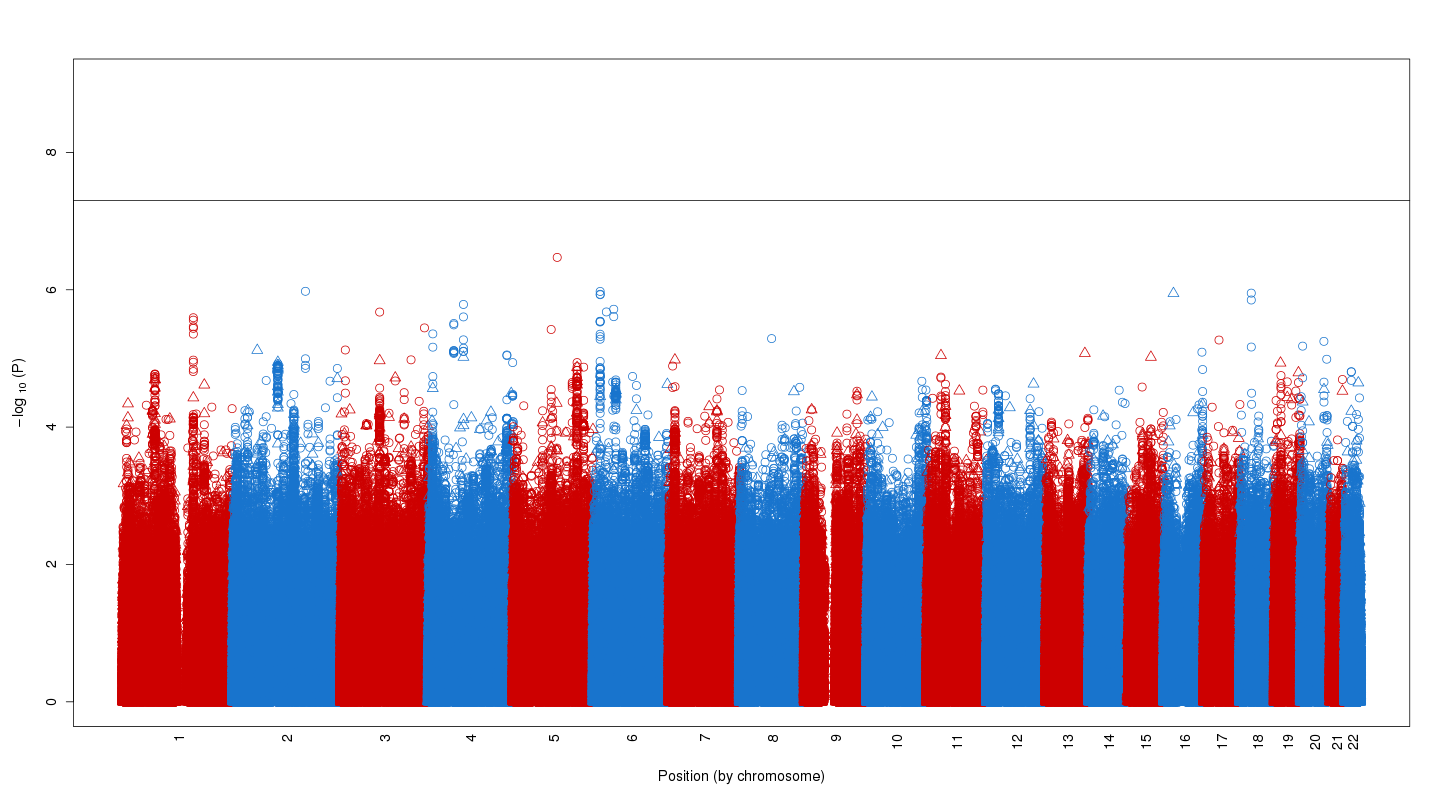
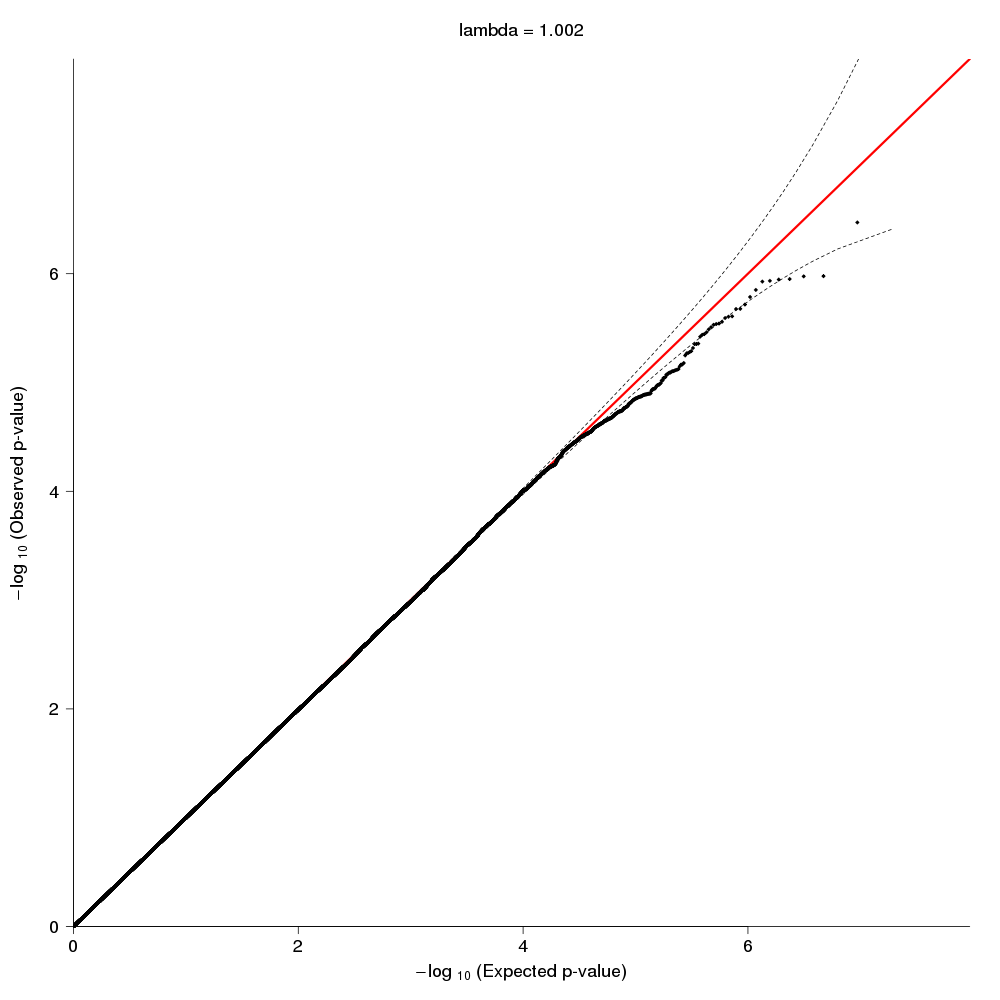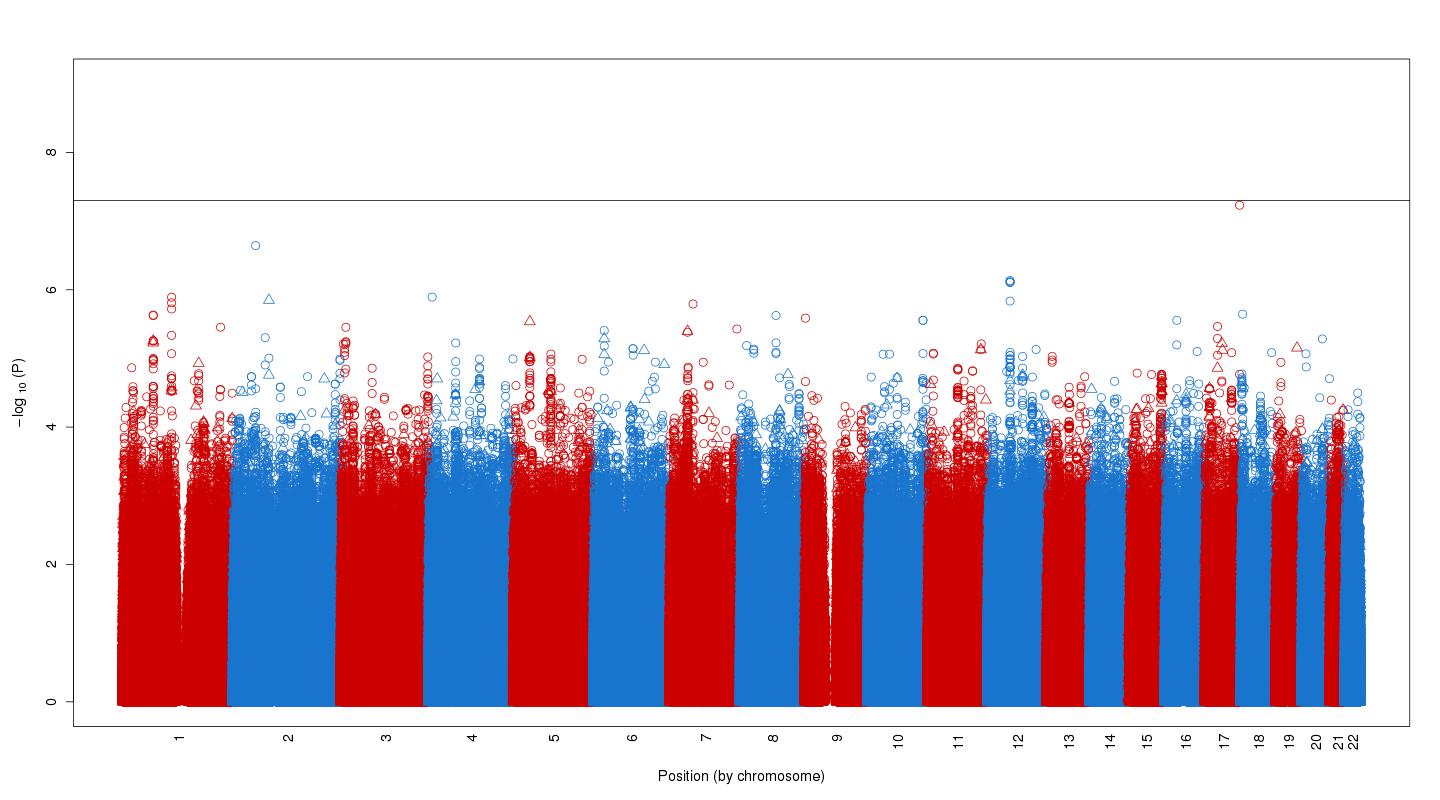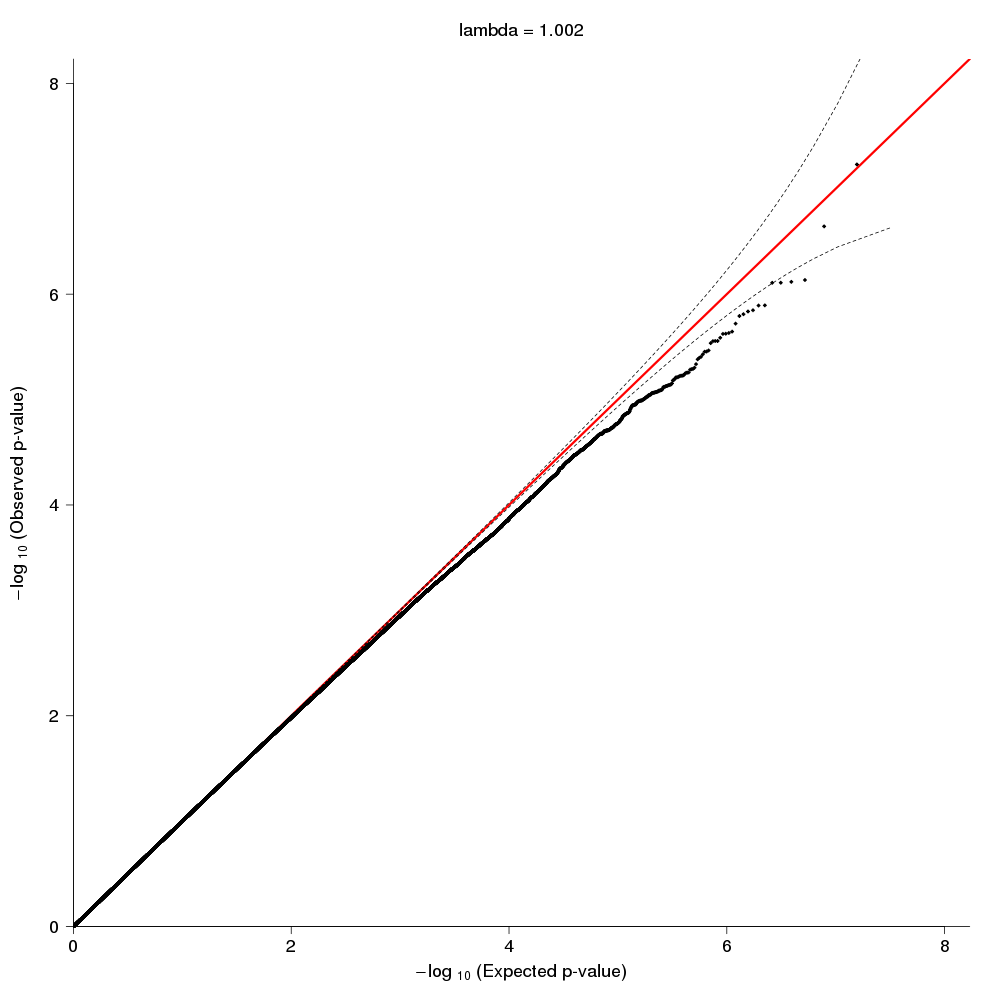

In [ ]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/gwas/fou/figures/UHS4.EUR.1000G.fou.assoc.plot.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/gwas/fou/figures/UHS4.EUR.1000G.fou.assoc.plot.snps+indels.qq.png")  
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/gwas/fou/figures/UHS4.AFR.1000G.fou.assoc.plot.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/uhs4/gwas/fou/figures/UHS4.AFR.1000G.fou.assoc.plot.snps+indels.qq.png")  

# S3 upload

In [ ]:
#/shared/jmarks/heroin/uhs4/gwas/fou/{ea,aa}/001/processing 
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
       --job_name gzip.files.$chr \
       --script_prefix gzip.files \
       --mem 25 \
       --nslots 3 \
       --priority 0 \
       --program  gzip -r chr$chr/ 
done